<a href="https://colab.research.google.com/github/JacobDowns/CSCI-491-591/blob/main/lecture2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example: Doing Something Interesting with Numpy




In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# Constants
A_PIPE = 0.6
G = 9.81
L_PIPE = 1
LX = 1
LY = 1
K_E = 0.003

In [4]:
from scipy.ndimage import gaussian_filter

def generate_terrain(n, steps=10):
  z = np.zeros((n, n))
  for i in range(steps):
    z_i = np.random.randn(n, n)
    sigma = float(n/(2.*(i+1)))
    z_i = gaussian_filter(z_i, sigma = sigma)
    z += z_i
  z = (z - z.min()) / (z.max() - z.min())
  return z



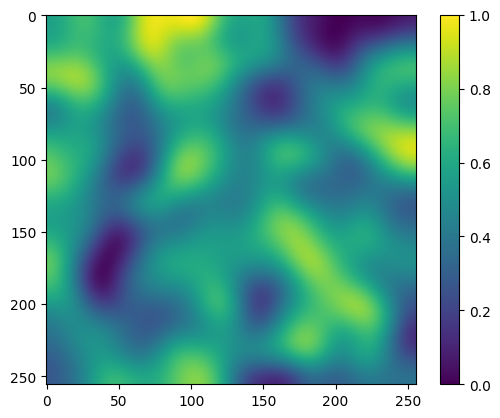

In [11]:
N = 256
z = 1.*generate_terrain(N)
plt.imshow(z)
plt.colorbar()
plt.show()

In [30]:
def update_flow(z, h, r, fL, fR, fT, fB, dt, k_e=K_E):
    ny, nx = z.shape
    inner = (slice(1, ny-1), slice(1, nx-1))

    # 3.1 Water increment
    h1 = h + dt * r
    H  = z + h

    # 3.2.1 Outflow flux (eqns 2–3)
    flux_factor = dt * A_PIPE / L_PIPE * G
    dhL = H[inner] - H[1:-1, 0:-2]
    dhR = H[inner] - H[1:-1, 2:  ]
    dhT = H[inner] - H[0:-2, 1:-1]
    dhB = H[inner] - H[2:  , 1:-1]

    fL[inner] = np.maximum(0.0, fL[inner] + dhL * flux_factor)
    fR[inner] = np.maximum(0.0, fR[inner] + dhR * flux_factor)
    fT[inner] = np.maximum(0.0, fT[inner] + dhT * flux_factor)
    fB[inner] = np.maximum(0.0, fB[inner] + dhB * flux_factor)

    # 3.2.1 Adjustment (eqns 4–5) on inner only
    sum_f_inner = fL[inner] + fR[inner] + fT[inner] + fB[inner]
    with np.errstate(divide='ignore', invalid='ignore'):
        factor = np.minimum(1.0, (h1[inner] * LX * LY) / (sum_f_inner * dt))
    factor = np.where(sum_f_inner > 0.0, factor, 1.0)
    fL[inner] *= factor
    fR[inner] *= factor
    fT[inner] *= factor
    fB[inner] *= factor

    # Edges zero to prevent leaking (after eqn 5)
    fL[0, :]  = 0.0
    fR[-1, :] = 0.0
    fT[:, 0]  = 0.0
    fB[:, -1] = 0.0

    # 3.2.2 Water surface update (eqns 6–7)
    sum_f_in  = (fR[1:-1, 0:-2] + fT[2:  , 1:-1] +
                 fL[1:-1, 2:  ] + fB[0:-2, 1:-1])
    sum_f_out = fL[inner] + fR[inner] + fT[inner] + fB[inner]

    dvol      = dt * (sum_f_in - sum_f_out)
    dh_inner  = dvol / (LX * LY)
    h2_inner  = h1[inner] + dh_inner

    # 3.5 Evaporation (constant rate)
    h_out = h.copy()
    h_out[inner] = np.maximum(0.0, h2_inner - k_e * dt)

    return h_out, fL, fR, fT, fB


In [41]:
import numpy as np

N = 128
steps = 500
dt = 0.1
rain_rate = 5e-3   # per-second rainfall while raining
evap_rate = 0.003  # constant evaporation rate (k_e in the vectorized function)
z = generate_terrain(N)

# --- fields
h  = np.zeros((N, N), dtype=np.float32)  # water height
fL = np.zeros_like(h)                      # fluxes persist across steps
fR = np.zeros_like(h)
fT = np.zeros_like(h)
fB = np.zeros_like(h)

# initial rainfall everywhere
r = np.full((N, N), rain_rate, dtype=np.float32)

results = np.zeros((steps, N, N))

# --- main loop
for t in range(steps):
    # simple schedule: rain for first half, then stop
    #if t == steps // 2:
    #    r.fill(0.0)

    # vectorized water update + velocities
    h, fL, fR, fT, fB = update_flow(
        z=z, h=h, r=r, fL=fL, fR=fR, fT=fT, fB=fB, dt=dt, k_e=evap_rate
    )
    results[t] = h

    if (t % 50) == 0 or (t == steps - 1):
        total_water = float(h.sum())
        max_h = float(h.max())
        print(f"step {t:4d} | total water = {total_water:.3f} | max h = {max_h:.4f}")

# results now in z (unchanged here), h, u, v, and fluxes fL/fR/fT/fB
# You can visualize with matplotlib:
# import matplotlib.pyplot as plt
# plt.figure(); plt.title("Water height h"); plt.imshow(h); plt.colorbar(); plt.show()
# plt.figure(); plt.title("Terrain z"); plt.imshow(z); plt.colorbar(); plt.show()





step    0 | total water = 3.196 | max h = 0.0010
step   50 | total water = 144.596 | max h = 0.1640
step  100 | total water = 259.819 | max h = 0.2553
step  150 | total water = 366.605 | max h = 0.3191
step  200 | total water = 467.316 | max h = 0.3670
step  250 | total water = 554.433 | max h = 0.3847
step  300 | total water = 627.444 | max h = 0.3988
step  350 | total water = 685.887 | max h = 0.4141
step  400 | total water = 722.337 | max h = 0.4216
step  450 | total water = 731.906 | max h = 0.4308
step  499 | total water = 723.236 | max h = 0.4421


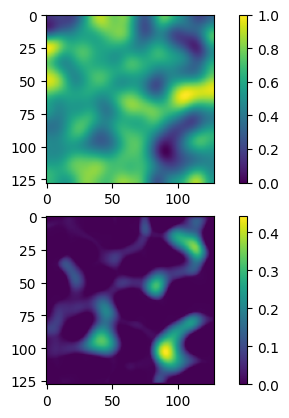

In [44]:
plt.subplot(2,1,1)
plt.imshow(z)
plt.colorbar()

plt.subplot(2,1,2)
plt.imshow(results[-1,:,:])
plt.colorbar()
plt.show()